In [1]:
import os
import json
import torch
import numpy as np
import collections
import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.util import ngrams

from transformers import AutoTokenizer
import matplotlib.pyplot as plt

/home/aigo/anaconda3/envs/torchfly/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def clean(x):
    x = x.strip("\n")
    x = x.strip("<s>").strip("</s>")
    return x

In [3]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [4]:
# temperatures = (np.arange(5) + 1) / 5.0
temperatures = (np.arange(10) + 1) / 10.0

In [5]:
def compute_bleu(inputs, n=2):
    if n==3:
        weights=(0.333, 0.333, 0.333, 0) 
    elif n==2:
        weights=(0.5, 0.5, 0.0, 0)
    elif n==4:
        weights=(0.25, 0.25, 0.25, 0.25)
    else:
        assert False

    scores = []
    
    for item in inputs:
        ref = nltk.word_tokenize(item[0].lower())
        hyp = nltk.word_tokenize(item[1].lower())
        
        score = sentence_bleu([ref], hyp, weights=weights)
        scores.append(score)
    return np.mean(scores)

In [6]:
def compute_distinct(inputs, n=4):
    counter = collections.Counter()
    total_count = 0
    
    for item in inputs:
        hyp = nltk.word_tokenize(item[1].lower())
        n_grams = list(ngrams(hyp, n=n))   
        counter.update(n_grams)
        total_count += len(n_grams)
    return len(counter) / total_count

In [7]:
def compute_unique(inputs, n=4):
    counter = collections.Counter()
    
    for item in inputs:
        tokens = nltk.word_tokenize(item[1].lower())
        n_grams = ngrams(tokens, n=n)   
        counter.update(n_grams)
    return len(counter)

In [8]:
def get_human_n_grams(inputs, n=4):
    human_n_grams = collections.Counter()

    for item in tqdm.tqdm(inputs):
        list_n_grams = ngrams(nltk.word_tokenize(item.lower()), n=n)
        human_n_grams.update(list_n_grams)
        
    human_n_grams = {k:v for k,v in human_n_grams.items() if v > 1}
    return human_n_grams

In [9]:
def compute_sentence_repeat(inputs, human_n_grams, n=4):
    scores = []
    for item in inputs:
        count = 0
        tokens = nltk.word_tokenize(item[1].lower())
        n_grams = list(ngrams(tokens, n=n))
        for n_gram in n_grams:
            if n_gram in human_n_grams:
                count += 1
        if len(n_grams) == 0:
            scores.append(0)
        else:
            scores.append(count/len(n_grams))

    return np.mean(scores)

In [10]:
task_name = "CommonGEN"
random_seed = "1"

In [11]:
with open(f"../../data/{task_name}/train.jsonl") as f:
    train_human_data = f.readlines()
    train_human_data = [json.loads(item)['target'] for item in train_human_data]

In [12]:
with open(f"../../data/{task_name}/test.jsonl") as f:
    test_human_data = f.readlines()
    test_human_data = [json.loads(item)['target'] for item in test_human_data]

In [13]:
method = "mle"
mle = []

for temperature in temperatures:
    with open(f"{task_name}/{method}_{temperature}_{random_seed}.txt") as f:
        data = f.readlines()
        data = [json.loads(item) for item in data]

    mle.append(compute_unique(data, n=2))

method = "textgail"
textgail = []

for temperature in temperatures:
    with open(f"{task_name}/{method}_{temperature}_{random_seed}.txt") as f:
        data = f.readlines()
        data = [json.loads(item) for item in data]

    textgail.append(compute_unique(data, n=2))

In [14]:
human = compute_unique([(item[0], item[1]) for item in data], n=2)

Text(0, 0.5, 'Unique 2-grams')

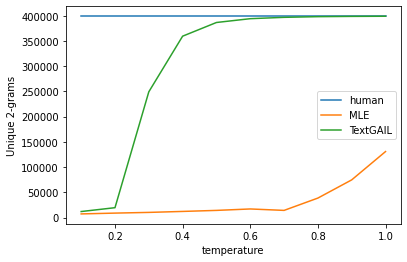

In [15]:
plt.plot(temperatures, [human] * len(mle))
plt.plot(temperatures, mle)
plt.plot(temperatures, textgail)
plt.legend(["human", "MLE", "TextGAIL"])
plt.xlabel("temperature")
plt.ylabel("Unique 2-grams")
# plt.savefig("unique2.png", dpi=300)

In [16]:
if task_name == "ROCStories":
    n = 2
else:
    n = 2

In [40]:
method = "mle"
mle = []
for temperature in temperatures:
    with open(f"{task_name}/{method}_{temperature}_{random_seed}.txt") as f:
        data = f.readlines()
        data = [json.loads(item) for item in data]
        
    mle.append(compute_bleu(data, n=n))

print(mle)
    
method = "textgail"
textgail = []
for temperature in temperatures:
    with open(f"{task_name}/{method}_{temperature}_{random_seed}.txt") as f:
        data = f.readlines()
        data = [json.loads(item) for item in data]
        
    textgail.append(compute_bleu(data, n=n))

print(textgail)

[0.14193756286984544, 0.140272355476338, 0.13528868236298675, 0.13487016223672604, 0.12809270543294896, 0.1190934169723697, 0.1175213290801326, 0.09163583780031483, 0.06864390779767565, 0.04742162163850224]
[0.10805746398766942, 0.09731913036640838, 0.04768882118016013, 0.013323675332936349, 0.0034618193696996005, 0.0013584677908225784, 0.000309922397833472, 0.00012166404182752561, 2.382476309931951e-05, 2.8371892425536168e-06]


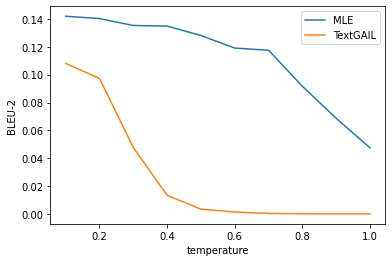

In [18]:
plt.plot(temperatures, mle)
plt.plot(temperatures, textgail)
plt.legend(["MLE", "TextGAIL"])
plt.xlabel("temperature")
plt.ylabel(f"BLEU-{n}")
plt.savefig(f"bleu{n}.png", dpi=300)

In [41]:
with open(f"{task_name}/Quality-Diversity/mle_bleu.txt", "w") as f:
    line = json.dumps(mle)
    f.write(line)
    f.write("\n")

In [42]:
with open(f"{task_name}/Quality-Diversity/textgail_bleu.txt", "w") as f:
    line = json.dumps(textgail)
    f.write(line)
    f.write("\n")

In [19]:
n = 2

In [20]:
human_n_grams = get_human_n_grams(train_human_data[:40000], n=n)

100%|██████████| 39069/39069 [00:03<00:00, 12618.68it/s]


In [21]:
method = "mle"
mle = []

for temperature in temperatures:
    with open(f"{task_name}/{method}_{temperature}_{random_seed}.txt") as f:
        data = f.readlines()
        data = [json.loads(item) for item in data]

    mle.append(compute_sentence_repeat(data, human_n_grams, n=n))

method = "textgail"
textgail = []

for temperature in temperatures:
    with open(f"{task_name}/{method}_{temperature}_{random_seed}.txt") as f:
        data = f.readlines()
        data = [json.loads(item) for item in data]

    textgail.append(compute_sentence_repeat(data, human_n_grams, n=n))

print(mle)
print(textgail)

[0.5680000121876699, 0.5695105252609203, 0.5747963896403699, 0.5760409042890386, 0.569320007162178, 0.5617964840853292, 0.5405399045145244, 0.5051803506693652, 0.44677815991071096, 0.3830880518727275]
[0.6952979205535555, 0.658528994064015, 0.2715924320921751, 0.0728676740268851, 0.021301716028979022, 0.007592815931348529, 0.0020634768441010077, 0.0007674483157654193, 0.0004204017169470413, 0.0002603116432595906]


In [22]:
human = compute_sentence_repeat(zip(test_human_data, test_human_data), human_n_grams, n=2)

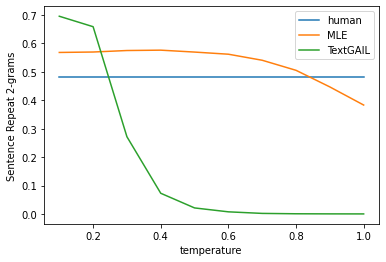

In [23]:
plt.plot(temperatures, [human] * len(mle))
plt.plot(temperatures, mle)
plt.plot(temperatures, textgail)
plt.legend(["human", "MLE", "TextGAIL"])
plt.xlabel("temperature")
plt.ylabel(f"Sentence Repeat {n}-grams")
plt.savefig("seprep2.png", dpi=300)

## Distinct-1/2

In [43]:
n = 2

method = "mle"
mle = []

for temperature in temperatures:
    with open(f"{task_name}/{method}_{temperature}_{random_seed}.txt") as f:
        data = f.readlines()
        data = [json.loads(item) for item in data]

    mle.append(compute_distinct(data, n=n))
print(mle)

method = "textgail"
textgail = []

for temperature in temperatures:
    with open(f"{task_name}/{method}_{temperature}_{random_seed}.txt") as f:
        data = f.readlines()
        data = [json.loads(item) for item in data]

    textgail.append(compute_distinct(data, n=n))
print(textgail)

[0.1157812930071402, 0.14234626700694095, 0.16386751205975833, 0.1833692256362037, 0.2041795531404457, 0.22281866862662747, 0.2950122035171162, 0.28446692870996526, 0.3372873546603547, 0.4151184121160572]
[0.06094934594330652, 0.09137222370634909, 0.8115183246073299, 0.9414056261699371, 0.9585417482562549, 0.9642989913615152, 0.9659607190396582, 0.9658585794899278, 0.9668867108047894, 0.9670166988108275]


In [25]:
human = compute_distinct([(item[0], item[0]) for item in data], n=n)

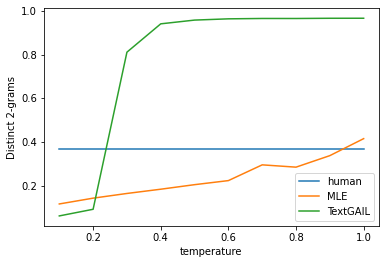

In [26]:
plt.plot(temperatures, [human] * len(mle))
plt.plot(temperatures, mle)
plt.plot(temperatures, textgail)
plt.legend(["human", "MLE", "TextGAIL"])
plt.xlabel("temperature")
plt.ylabel(f"Distinct {n}-grams")
plt.savefig(f"{task_name}distinct-{n}.png", dpi=300)

In [44]:
with open(f"{task_name}/Quality-Diversity/mle_distinct.txt", "w") as f:
    line = json.dumps(mle)
    f.write(line)
    f.write("\n")

In [45]:
with open(f"{task_name}/Quality-Diversity/textgail_distinct.txt", "w") as f:
    line = json.dumps(textgail)
    f.write(line)
    f.write("\n")

## Beam-Search

In [27]:
if task_name == "ROCStories":
    n = 2
else:
    n = 2

In [28]:
method = "textgail"

with open(f"{task_name}/{method}_beam_4.txt") as f:
    data = f.readlines()
    data = [json.loads(item) for item in data]

print(compute_bleu(data, n=n))

FileNotFoundError: [Errno 2] No such file or directory: 'CommonGEN/textgail_beam_4.txt'

In [ ]:
print(compute_unique(data, n=2))

3840


In [ ]:
compute_sentence_repeat(data, human_n_grams, n=2)

0.6980312197852808

In [ ]:
compute_distinct(data, n=n)

0.09516492775891551

In [ ]:
filename = f"CommonGEN/textgail_reinforce2_beam_4.txt"
filename = f"/home/wuqy1203/Desktop/WorkingProjects/TextGAIL/Conditional/Evaluation/CommonGEN/2mle_beam_4.txt"

In [ ]:
method = "textgail"
with open(filename) as f:
    data = f.readlines()
    data = [json.loads(item) for item in data]

print(compute_bleu(data, n=n))

/home/wuqy1203/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/wuqy1203/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/wuqy1203/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

0.16069196474763123


In [ ]:
compute_distinct([data[0] if np.random.rand() > 0.5 else data[-1] for item in data], n=2)

0.0003150976802808871

In [ ]:
compute_sentence_repeat(data, human_n_grams, n=2)

0.7047190882566753

In [ ]:
0.16782066640947024 / 2

0.08391033320473512

In [ ]:
def compute_distinct(inputs, n=4):
    counter = collections.Counter()
    total_count = 0
    
    for item in inputs:
        hyp = nltk.word_tokenize(item[1].lower())
        n_grams = list(ngrams(hyp, n=n))   
        counter.update(n_grams)
        total_count += len(n_grams)
        
    return len(counter) / total_count